<a href="https://colab.research.google.com/github/pavanpinninti/Similar-Image-Search/blob/master/SimilarImageSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/pavanpinninti/Similar-Image-Search.git

Cloning into 'Similar-Image-Search'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4743 (delta 0), reused 3 (delta 0), pack-reused 4740
Receiving objects: 100% (4743/4743), 265.44 MiB | 39.92 MiB/s, done.
Checking out files: 100% (4740/4740), done.


In [2]:
import cv2
import numpy as np
import scipy
from scipy import spatial
from imageio import imread
import pickle
import random
import os
import matplotlib.pyplot as plt


In [3]:
# Feature extractor
def extract_features(image_path, vector_size=32):
    image = imread(image_path, pilmode="RGB")
    try:
        # Using KAZE
        alg = cv2.KAZE_create()
        # Dinding image keypoints
        kps = alg.detect(image)
        # Getting first 32 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        # Flatten all of them in one big vector - our feature vector
        dsc = dsc.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print('Error: ', e)
        return None

    return dsc


def batch_extractor(images_path, pickled_db_path="/content/Similar-Image-Search/features.pck"):
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]

    result = {}
    for f in files:
        print ('Extracting features from image %s' % f)
        name = f.split('/')[-1].lower()
        result[name] = extract_features(f)
    
    # saving all our feature vectors in pickled file
    with open(pickled_db_path, 'wb') as fp:
        pickle.dump(result, fp)

In [5]:
class Matcher(object):

    def __init__(self, pickled_db_path="/content/Similar-Image-Search/features.pck"):
        with open(pickled_db_path,'rb') as fp:
            self.data = pickle.load(fp)
        self.names = []
        self.matrix = []
        for k, v in self.data.items():
            self.names.append(k)
            self.matrix.append(v)
        self.matrix = np.array(self.matrix)
        self.names = np.array(self.names)

    def cos_cdist(self, vector):
        # getting cosine distance between search image and images database
        v = vector.reshape(1, -1)
        return scipy.spatial.distance.cdist(self.matrix, v, 'cosine').reshape(-1)

    def match(self, image_path, topn=5):
        features = extract_features(image_path)
        img_distances = self.cos_cdist(features)
        # getting top n records
        nearest_ids = np.argsort(img_distances)[:topn].tolist()
        nearest_img_paths = self.names[nearest_ids].tolist()

        return nearest_img_paths, img_distances[nearest_ids].tolist()

Saving 6.jpg to 6.jpg
No. Of similar images you need = 5
Query image ==========================================


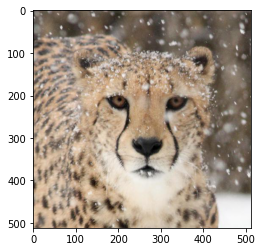

Result images ========================================
Match 1.0


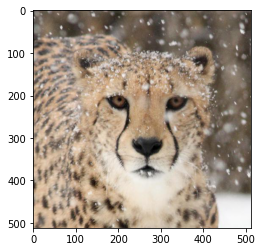

Match 0.8136378609202549


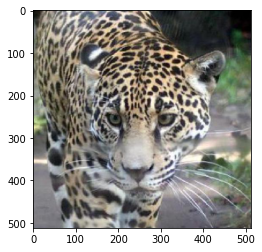

Match 0.8136013379225098


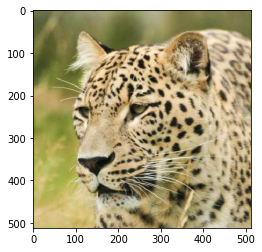

Match 0.8125551451902491


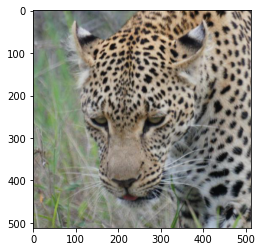

Match 0.8108830119236641


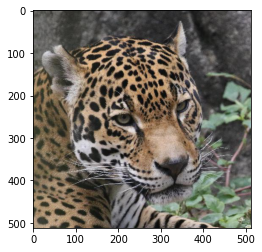

In [7]:
def show_img(path):
    img = imread(path, pilmode="RGB")
    plt.imshow(img)
    plt.show()
    
def run():
    images_path = '/content/Similar-Image-Search/dataset/'
    # images_path = '/content/drive/My Drive/Similarimagesearch/dataset/'
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    # getting images 
    from google.colab import files
    from io import BytesIO
    uploaded = files.upload()

    sample = uploaded
    # batch_extractor(images_path)

    ma = Matcher('/content/Similar-Image-Search/features.pck')
    temp = int(input("No. Of similar images you need = "))
    for s in sample:
        print ('Query image ==========================================')
        show_img(s)
        names, match = ma.match(s, topn=temp)
        print ('Result images ========================================')
        for i in range(temp):
            # we got cosine distance, less cosine distance between vectors
            # more they similar, thus we subtruct it from 1 to get match value
            print ('Match %s' % (1-match[i]))
            show_img(os.path.join(images_path, names[i]))

run()